In [1]:
!pip install ipydeps

     |████████████████████████████████| 61kB 3.1MB/s 
     |████████████████████████████████| 2.7MB 7.4MB/s 
  Created wheel for ipydeps: filename=ipydeps-0.10.0-cp36-none-any.whl size=10798 sha256=1613e0d6b50fc0cbad7cb40e8da07ce2ee8c10e138544af929f61a0accf23dfe
  Stored in directory: /root/.cache/pip/wheels/e3/4a/6f/2a1810efd60598edd3f3a3d800bb46f734407dd62c18710534
  Created wheel for pypki2: filename=pypki2-0.11.0-cp36-none-any.whl size=10428 sha256=f2abdccab3cc60e3e5bd8718f15ae98bd50e02a844a86fede0b94c74603c9916
  Stored in directory: /root/.cache/pip/wheels/94/40/0b/348ab8c4a7ccd1f846f0b7a011065f70b06a53c7accf84a301
Successfully built ipydeps pypki2


In [2]:
import ipydeps
ipydeps.pip(["keras-rl", "gym"])

In [3]:
!pip uninstall tensorflow==2.0.0-beta

Uninstalling tensorflow-2.2.0rc4:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.6/dist-packages/tensorflow-2.2.0rc4.dist-info/*
    /usr/local/lib/python3.6/dist-packages/tensorflow/*
Proceed (y/n)? y
  Successfully uninstalled tensorflow-2.2.0rc4


In [4]:
!pip install tensorflow==1.13.1

     |████████████████████████████████| 92.5MB 113kB/s 
     |████████████████████████████████| 3.2MB 49.1MB/s 
     |████████████████████████████████| 368kB 45.9MB/s 
  Found existing installation: tensorboard 2.2.1
    Uninstalling tensorboard-2.2.1:
      Successfully uninstalled tensorboard-2.2.1
  Found existing installation: tensorflow-estimator 2.2.0
    Uninstalling tensorflow-estimator-2.2.0:
      Successfully uninstalled tensorflow-estimator-2.2.0


In [5]:
import numpy as np
import gym
from gym import spaces
from gym.utils import seeding

import tensorflow as tf
import datetime

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

from rl.agents.dqn import DQNAgent
from rl.policy import BoltzmannQPolicy
from rl.memory import SequentialMemory

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

In [0]:
import copy
import random
def cmp(a, b):
    return float(a > b) - float(a < b)

# 1 = Ace, 2-10 = Number cards, Jack/Queen/King = 10
deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]
deck2 = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]
countn = 0
gsums = 0
rewards = 0


def draw_card(rand):
    global countn
    curr = deck[rand]
    deck.remove(curr)
    if int(curr) == 1 or int(curr) == 10:
        countn -= 1
    elif int(curr) < 7 and int(curr) != 1:
        countn += 1
    return int(curr)


def draw_hand():
    return [draw_card(random.randint(0, len(deck)-1)), draw_card(random.randint(0, len(deck)-1))]


def usable_ace(hand):  # Does this hand have a usable ace?
    return 1 in hand and sum(hand) + 10 <= 21


def sum_hand(hand):  # Return current hand total
    if usable_ace(hand):
        return sum(hand) + 10
    return sum(hand)


def is_bust(hand):  # Is this hand a bust?
    return sum_hand(hand) > 21


def score(hand):  # What is the score of this hand (0 if bust)
    return 0 if is_bust(hand) else sum_hand(hand)


def is_natural(hand):  # Is this hand a natural blackjack?
    return sorted(hand) == [1, 10]


class CountBlackjackEnv(gym.Env):
    """Simple blackjack environment
    Blackjack is a card game where the goal is to obtain cards that sum to as
    near as possible to 21 without going over.  They're playing against a fixed
    dealer.
    Face cards (Jack, Queen, King) have point value 10.
    Aces can either count as 11 or 1, and it's called 'usable' at 11.
    This game is placed with an infinite deck (or with replacement).
    The game starts with each (player and dealer) having one face up and one
    face down card.
    The player can request additional cards (hit=1) until they decide to stop
    (stick=0) or exceed 21 (bust).
    After the player sticks, the dealer reveals their facedown card, and draws
    until their sum is 17 or greater.  If the dealer goes bust the player wins.
    If neither player nor dealer busts, the outcome (win, lose, draw) is
    decided by whose sum is closer to 21.  The reward for winning is +1,
    drawing is 0, and losing is -1.
    The observation of a 3-tuple of: the players current sum,
    the dealer's one showing card (1-10 where 1 is ace),
    and whether or not the player holds a usable ace (0 or 1).
    This environment corresponds to the version of the blackjack problem
    described in Example 5.1 in Reinforcement Learning: An Introduction
    by Sutton and Barto.
    http://incompleteideas.net/book/the-book-2nd.html
    """
    def __init__(self, natural=False):
        self.action_space = spaces.Discrete(2)
        self.observation_space = spaces.Tuple((
            spaces.Discrete(32),
            spaces.Discrete(40),
            spaces.Discrete(2),
            spaces.Discrete(11),
            spaces.Discrete(52)))

        # Flag to payout 1.5 on a "natural" blackjack win, like casino rules
        # Ref: http://www.bicyclecards.com/how-to-play/blackjack/
        self.natural = natural
        # Start the first game
        self.reset()


    def step(self, action):
        global deck
        global countn
        global gsums
        global rewards
        assert self.action_space.contains(action)
        if action:  # hit: add a card to players hand and return
            if len(deck) == 0:
                deck = copy.copy(deck2)
                countn = 0
            self.player.append(draw_card(random.randint(0, len(deck)-1)))
            if is_bust(self.player):
                done = True
                #rewards = -1
                reward = -1
            else:
                done = False
                #rewards = 0
                reward = 0
        else:  # stick: play out the dealers hand, and score
            done = True
            while sum_hand(self.dealer) < 17:
                if len(deck) == 0:
                    deck = copy.copy(deck2)
                    countn = 0
                self.dealer.append(draw_card(random.randint(0, len(deck)-1)))
            #rewards = cmp(score(self.player), score(self.dealer))
            reward = cmp(score(self.player), score(self.dealer))
            if is_natural(self.player) and reward == 1:
                #rewards = 1.5
                reward = 1.5
        rewards = reward
        return self._get_obs(), reward, done, {}

    def _get_obs(self):
        global gsums
        gsums = sum_hand(self.player)
        return (sum_hand(self.player), countn, usable_ace(self.player), self.dealer[0], len(deck))

    def reset(self):
        global deck
        global countn
        if len(deck) < 4:
            deck = copy.copy(deck2)
            countn = 0
        self.dealer = draw_hand()
        self.player = draw_hand()
        return self._get_obs()

In [0]:
env = CountBlackjackEnv()
np.random.seed(123)
env.seed(123)
nb_actions = env.action_space.n

In [0]:
from keras.callbacks import LambdaCallback, CSVLogger, TensorBoard

log = [[],[],[]]
def on_epoch_end(epoch, logs):
    log[0].append(rewards)
    log[1].append(gsums)
    log[2].append(countn)
l_cb = LambdaCallback(on_epoch_end=on_epoch_end)
cb_list = [l_cb]

In [233]:
model = Sequential()
model.add(Flatten(input_shape=(1,5)))
model.add(Dense(16))
model.add(Activation('relu'))
model.add(Dense(16))
model.add(Activation('relu'))
model.add(Dense(16))
model.add(Activation('relu'))
model.add(Dense(nb_actions))
model.add(Activation('linear'))

model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_18 (Flatten)         (None, 5)                 0         
_________________________________________________________________
dense_69 (Dense)             (None, 16)                96        
_________________________________________________________________
activation_69 (Activation)   (None, 16)                0         
_________________________________________________________________
dense_70 (Dense)             (None, 16)                272       
_________________________________________________________________
activation_70 (Activation)   (None, 16)                0         
_________________________________________________________________
dense_71 (Dense)             (None, 16)                272       
_________________________________________________________________
activation_71 (Activation)   (None, 16)              

In [0]:
memory = SequentialMemory(limit=50000, window_length=1)
policy = BoltzmannQPolicy()
dqn = DQNAgent(model=model, nb_actions=nb_actions, memory=memory, nb_steps_warmup=10,
               target_model_update=5, policy=policy)
dqn.compile(Adam(lr=1e-3), metrics=['mae'])

In [259]:
len(log[0])

0

In [273]:
dqn.fit(env, nb_steps=100000, visualize=False, verbose=1)

Training for 100000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 177s 18ms/step - reward: -0.1562
7199 episodes - episode_reward: -0.217 [-1.000, 1.500] - loss: 0.262 - mae: 0.527 - mean_q: 0.023

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 180s 18ms/step - reward: -0.1495
7176 episodes - episode_reward: -0.208 [-1.000, 1.500] - loss: 0.262 - mae: 0.529 - mean_q: 0.033

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 180s 18ms/step - reward: -0.1617
7225 episodes - episode_reward: -0.224 [-1.000, 1.500] - loss: 0.263 - mae: 0.530 - mean_q: 0.030

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 181s 18ms/step - reward: -0.1570
7207 episodes - episode_reward: -0.218 [-1.000, 1.500] - loss: 0.262 - mae: 0.531 - mean_q: 0.030

Interval 5 (40000 steps performed)
10000/10000 [==============================] - 179s 18ms/step - reward: -0.1580
712

In [275]:
tests = dqn.test(env, nb_episodes=20000, visualize=False, callbacks=cb_list)

Streaming output truncated to the last 5000 lines.
Episode 15002: reward: 1.500, steps: 1
Episode 15003: reward: -1.000, steps: 2
Episode 15004: reward: 1.000, steps: 1
Episode 15005: reward: 0.000, steps: 1
Episode 15006: reward: -1.000, steps: 3
Episode 15007: reward: -1.000, steps: 1
Episode 15008: reward: 1.000, steps: 1
Episode 15009: reward: 1.000, steps: 2
Episode 15010: reward: 1.000, steps: 2
Episode 15011: reward: -1.000, steps: 1
Episode 15012: reward: -1.000, steps: 2
Episode 15013: reward: -1.000, steps: 3
Episode 15014: reward: -1.000, steps: 1
Episode 15015: reward: -1.000, steps: 1
Episode 15016: reward: -1.000, steps: 1
Episode 15017: reward: -1.000, steps: 1
Episode 15018: reward: 1.000, steps: 2
Episode 15019: reward: -1.000, steps: 1
Episode 15020: reward: 1.500, steps: 1
Episode 15021: reward: 1.000, steps: 2
Episode 15022: reward: -1.000, steps: 1
Episode 15023: reward: 0.000, steps: 1
Episode 15024: reward: 0.000, steps: 2
Episode 15025: reward: -1.000, steps: 2


In [276]:
len(log[0])

40000

-472.5
18.924925


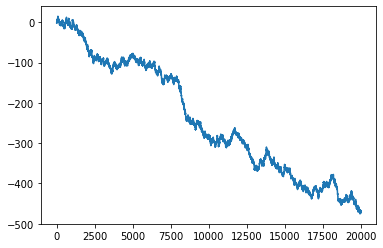

In [281]:
import matplotlib.pyplot as plt
import numpy as np
track = len(log[0])
wander = 0
y = np.zeros(track)
for i in range(0, 20000):
  wander += log[0][i]
  y[i] = wander
print(wander)
x = np.linspace(0, 20000, 20000)
plt.plot()
plt.plot(x, y[0:20000])
#plt.plot(x, np.cos(x))
print(sum(log[1])/len(log[1]))

plt.show()

In [0]:
# Mr. Kyle King. 2020 March 6-7.Assistance given to the author, verbal discussion and electronic copying.
# https://gist.github.com/kylekyle/ba1d0d716b644e83495e95d68418167a Using this code and 
# verabl discussion Mr. King helped me understand how to use a reinforcement learning model
# and create an agent.

In [0]:
# Mr. Matthias Plappert. 2020 March 6. Electronic copying. https://github.com/keras-rl/keras-rl
# I used Keras-rl for this project and the example dqn_cartpole.py to understand how to import
# Keras featurs and compile my blackjack agent.

In [0]:
# Open AI gym contributers. 2020 March 6. Electronic copying. https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py
# I modyfied the code from blackjack.py as my agent. Most of the methods from blackjack.py remain unchanged from the source.